# 4. Answering RQ4

📌 NOTE: This notebook is similar to previous notebook, but this time we will exclude all digital biomarker features and only use eye tracking data for our timeseries

---


In [ ]:
! pip install graphviz pydot

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import cv2
import random
import pickle

from scipy.ndimage import gaussian_filter

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Input, Concatenate, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

warnings.filterwarnings('ignore')
backend.clear_session()

In [ ]:
CECS_698_PATH = '/content/drive/MyDrive/CECS 698 - Data Analysis/'

PARTICIPANTS = [i for i in range(4, 27)]

FPOG_SCANPATHS_PATH = os.path.join(CECS_698_PATH, 'FPOG Scanpaths')

MERGED_DATA = os.path.join(CECS_698_PATH, 'Merged Data')

GOOGLE_FORMS_SHEETS = os.path.join(CECS_698_PATH, 'Google Forms Sheets')

# Particpants ids to exclude on specific assessments
EASY_ASSESSMENT_EXCLUDE = [11, 22]
HARD_ASSESSMENT_EXCLUDE = [15, 21]

# Size of image to store image files
IMG_SIZE=(70, 70)

# Gathering Data 📈
---

## Getting Scores

In [ ]:
df_scores = pd.read_csv(os.path.join(CECS_698_PATH, 'Participant Scores.csv'))
df_scores.head()

,Score,Participant ID,Assessment,Group,Elapsed Minutes,Successful/Unsuccessful,Python Experience,Year of Study
0,23,4,easy,E-H,10.933250,Successful,1 - 2 years,2nd Year Undergraduate
1,24,5,easy,E-H,7.933283,Successful,2 year or more,1st Year Graduate
2,26,6,easy,E-H,6.566667,Successful,1 - 2 years,3rd Year Undergraduate
3,25,7,easy,E-H,6.249933,Successful,1 - 2 years,3rd Year Undergraduate
4,20,8,easy,E-H,7.866567,Unsuccessful,1 - 2 years,3rd Year Undergraduate


## Combining Questionnaire Data

In [ ]:
# ----------------------------------------------- NASA TLX -----------------------------------------------
df_NASA_TLX = pd.read_csv(os.path.join(GOOGLE_FORMS_SHEETS, 'Participants Sheet - NASA TLX.csv'))#.drop('Dry Run?', axis=1)

df_NASA_TLX.columns = [
    'Timestamp',
    'Participant ID',
    'Mental Demand', # 1
    'Physical Demand', # 2
    'Temporal Demand', # 3
    'Performance', # 4
    'Effort', # 5
    'Frustration', # 6
    'Dry Run', # 7
]

df_NASA_TLX = df_NASA_TLX[df_NASA_TLX['Dry Run'].isnull()] # Take out dry run participants
df_NASA_TLX.drop(['Dry Run', 'Timestamp'], axis=1, inplace=True)


# ----------------------------------------------- Pre-Study KSS -----------------------------------------------
df_pre_study_KSS = pd.read_csv(os.path.join(GOOGLE_FORMS_SHEETS, 'Participants Sheet - Pre-Study KSS.csv'))
df_pre_study_KSS = df_pre_study_KSS[df_pre_study_KSS['Dry Run?'].isnull()]
df_pre_study_KSS.drop(['Dry Run?', 'Timestamp'], axis=1, inplace=True)
df_pre_study_KSS.columns = [
    'Participant ID',
    'Hours Awake',
    'Pre-Sleepiness Scale',
]
df_pre_study_KSS['Pre-Sleepiness Scale'] = df_pre_study_KSS['Pre-Sleepiness Scale'].apply(lambda x: int(x.split()[0]))


# ----------------------------------------------- Post-Study KSS -----------------------------------------------
df_post_study_KSS = pd.read_csv(os.path.join(GOOGLE_FORMS_SHEETS, 'Participants Sheet - Post-Study KSS.csv'))
df_post_study_KSS = df_post_study_KSS[df_post_study_KSS['Dry Run?'].isnull()]
df_post_study_KSS.drop(['Dry Run?', 'Timestamp'], axis=1, inplace=True)
df_post_study_KSS.columns = [
    'Participant ID',
    'Post-Sleepiness Scale',
]
df_post_study_KSS['Post-Sleepiness Scale'] = df_post_study_KSS['Post-Sleepiness Scale'].apply(lambda x: int(x.split()[0]))

df_all_questionnaires = df_NASA_TLX.merge(df_pre_study_KSS, on='Participant ID', how='inner').merge(df_post_study_KSS, on='Participant ID', how='inner')
df_all_questionnaires = df_all_questionnaires.merge(df_scores, left_on='Participant ID', right_on='Participant ID ').drop(columns=['Participant ID '])
df_all_questionnaires.head()

,Participant ID,Mental Demand,Physical Demand,Temporal Demand,Performance,Effort,Frustration,Hours Awake,Pre-Sleepiness Scale,Post-Sleepiness Scale,Score,Assessment,Group,Elapsed Minutes,Successful/Unsuccessful,Python Experience,Year of Study
0,4,6,7,1,7,5,3,7.0,8,2,23,easy,E-H,10.933250,Successful,1 - 2 years,2nd Year Undergraduate
1,4,6,7,1,7,5,3,7.0,8,2,24,hard,E-H,26.266650,Successful,1 - 2 years,2nd Year Undergraduate
2,5,6,1,2,4,5,6,3.0,7,7,24,easy,E-H,7.933283,Successful,2 year or more,1st Year Graduate
3,5,6,1,2,4,5,6,3.0,7,7,24,hard,E-H,26.933333,Successful,2 year or more,1st Year Graduate
4,6,3,5,2,6,4,2,7.0,5,7,26,easy,E-H,6.566667,Successful,1 - 2 years,3rd Year Undergraduate


In [ ]:
df_all_questionnaires.columns

Index(['Participant ID', 'Mental Demand', 'Physical Demand', 'Temporal Demand',
       'Performance', 'Effort', 'Frustration', 'Hours Awake',
       'Pre-Sleepiness Scale', 'Post-Sleepiness Scale', 'Score', 'Assessment',
       'Group', 'Elapsed Minutes', 'Successful/Unsuccessful',
       'Python Experience', 'Year of Study'],
      dtype='object')

## Get X, y data then `train_test_split`

Excluding digital biomarkers (NOTICE: In `read_X_timeseries` I will delete features relating to digital biomarkers)

In [ ]:
DROP_COLUMNS = ['eda_scl_usiemens', 'pulse_rate_bpm', 'temperature_celsius']

In [ ]:
def read_y_labels(path):
    y = []
    for p in PARTICIPANTS:
        for diff in ['easy', 'hard']:
            if (diff == 'easy' and p in EASY_ASSESSMENT_EXCLUDE) or (diff == 'hard' and p in HARD_ASSESSMENT_EXCLUDE):
                continue # Excluded assessments (i.e ones with data loss)

            label = df_scores[(df_scores['Participant ID '] == p) & (df_scores['Assessment'] == diff)]['Successful/Unsuccessful'].values[0]
            label = 1 if label == 'Successful' else 0
            y.append(label)

    y = np.array(y)

    return y

def read_X_timeseries(path):
    X = []
    for p in PARTICIPANTS:
        for diff in ['easy', 'hard']:
            if (diff == 'easy' and p in EASY_ASSESSMENT_EXCLUDE) or (diff == 'hard' and p in HARD_ASSESSMENT_EXCLUDE):
                continue # Excluded assessments (i.e ones with data loss)

            folder = f"Participant {p}"
            file = f"participant{p}_{diff}_assessment.csv"

            # Merged data path
            df = pd.read_csv(os.path.join(path, folder, file))
            df.set_index('timestamp_unix', inplace=True)
            df.drop(columns=DROP_COLUMNS, inplace=True)

            # Synthetic data path
            X.append(df)

    return X

def read_X_categorical(path):
    # Getting all dataframes and splitting them into 2 groups: Successful and Unsuccessful
    X = pd.DataFrame()

    features = ['Participant ID', 'Mental Demand', 'Physical Demand', 'Temporal Demand',
       'Performance', 'Effort', 'Frustration', 'Hours Awake',
       'Pre-Sleepiness Scale', 'Post-Sleepiness Scale', 'Assessment',
       'Group', 'Elapsed Minutes',
       'Python Experience', 'Year of Study']

    for p in PARTICIPANTS:
        for diff in ['easy', 'hard']:
            if (diff == 'easy' and p in EASY_ASSESSMENT_EXCLUDE) or (diff == 'hard' and p in HARD_ASSESSMENT_EXCLUDE):
                continue # Excluded assessments (i.e ones with data loss)

            filter = (df_all_questionnaires['Participant ID'] == p) & (df_all_questionnaires['Assessment'] == diff)
            df_participant = df_all_questionnaires[filter]

            X = pd.concat([X, df_participant[features]], axis=0)

    return X


# Helper function to read a single image
def read_image(img_path, img_size):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_size) # Resizing all images to make them uniform
    img = img.astype("float32") / 255.0  # Normalize
    return img

def read_X_image(path, img_size=IMG_SIZE):
    X = []

    for p in PARTICIPANTS:
        for diff in ['easy', 'hard']:
            if (diff == 'easy' and p in EASY_ASSESSMENT_EXCLUDE) or (diff == 'hard' and p in HARD_ASSESSMENT_EXCLUDE):
                continue # Excluded assessments (i.e ones with data loss)

            folder = f"Participant {p}"
            file = f"FPOG {diff}.png"

            # Reading in each image
            img_path = os.path.join(path, folder, file)
            img = read_image(img_path, img_size)
            X.append(img)

    X = np.array(X)
    return X

Train test splitting

In [ ]:
X_timeseries = read_X_timeseries(MERGED_DATA)
X_categorical = read_X_categorical(MERGED_DATA)
X_image = read_X_image(FPOG_SCANPATHS_PATH)
y = read_y_labels(MERGED_DATA)

print(f"X_timeseries: {len(X_timeseries)}, X_categorical: {len(X_categorical)}, X_image: {len(X_image)}, y_actual: {len(y)}")

X_timeseries_train, X_timeseries_test, \
X_categorical_train, X_categorical_test, \
X_image_train, X_image_test, \
y_train, y_test = train_test_split(
    X_timeseries, X_categorical, X_image, y,
    test_size=0.4,
    random_state=42,
    stratify=y
)

X_timeseries: 42, X_categorical: 42, X_image: 42, y_actual: 42


In [ ]:
def get_split_info(df):
    label_counts = {'Successful': 0, 'Unsuccessful': 0}
    participants_list, assessment_list = [], []

    for idx, row in df.iterrows():
        participant_id, assessment = row['Participant ID'], row['Assessment']
        participants_list.append(participant_id)
        assessment_list.append(assessment)

        label = df_scores[(df_scores['Participant ID '] == participant_id) & (df_scores['Assessment'] == assessment)]['Successful/Unsuccessful'].values[0]
        label_counts[label] += 1
        print(f"Participant {participant_id} ({assessment} assessment) - {label}")

    total = len(df)
    print(f"{label_counts} (Proportion successful: {(label_counts['Successful'] / total):.2f}, Proportion unsuccessful: {(label_counts['Unsuccessful'] / total):.2f})")

    return participants_list, assessment_list

Valdiating train and test data (Are they correctly split?)

In [ ]:
print(f'---------- TRAINING DATA ({len(X_categorical_train)}) ----------')
participant_id_train, assessment_train = get_split_info(X_categorical_train)

print()

print(f'---------- TEST DATA ({len(X_categorical_test)}) ----------')
label_counts = {'Successful': 0, 'Unsuccessful': 0}
participant_id_test, assessment_test = get_split_info(X_categorical_test)

---------- TRAINING DATA (25) ----------
Participant 19 (easy assessment) - Unsuccessful
Participant 21 (easy assessment) - Unsuccessful
Participant 14 (easy assessment) - Unsuccessful
Participant 6 (easy assessment) - Successful
Participant 12 (easy assessment) - Unsuccessful
Participant 5 (hard assessment) - Successful
Participant 25 (hard assessment) - Successful
Participant 9 (easy assessment) - Successful
Participant 7 (easy assessment) - Successful
Participant 7 (hard assessment) - Unsuccessful
Participant 20 (easy assessment) - Unsuccessful
Participant 10 (easy assessment) - Unsuccessful
Participant 26 (hard assessment) - Successful
Participant 6 (hard assessment) - Successful
Participant 16 (easy assessment) - Successful
Participant 8 (hard assessment) - Unsuccessful
Participant 9 (hard assessment) - Successful
Participant 22 (hard assessment) - Unsuccessful
Participant 23 (hard assessment) - Successful
Participant 5 (easy assessment) - Successful
Participant 16 (hard assessmen

# Data Preprocessing 🏭
---

## Preprocess timeseries data

In [ ]:
# Normalize each participant's DataFrame individually.
def scale_timeseries_data(X):
    X_scaled = []

    for df in X:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(df.values)
        # Create a new DataFrame to hold the scaled values
        scaled_df = pd.DataFrame(scaled_values, columns=df.columns)
        X_scaled.append(scaled_df)

    return X_scaled

In [ ]:
X_timeseries_train = scale_timeseries_data(X_timeseries_train)
X_timeseries_test = scale_timeseries_data(X_timeseries_test)

All time series are different lengths. We must use padding to have them the same lengths

In [ ]:
max_seq_length = 0

for sequence in X_timeseries_train + X_timeseries_test:
    max_seq_length = max(max_seq_length, len(sequence))

print(f"Padding with max sequence length: {max_seq_length}")


# Pad sequences to the max length (Expected: 248)
X_timeseries_train = pad_sequences(X_timeseries_train, maxlen=max_seq_length, padding='post', dtype='float32')
X_timeseries_test = pad_sequences(X_timeseries_test, maxlen=max_seq_length, padding='post', dtype='float32')

Padding with max sequence length: 248


In [ ]:
X_timeseries_train[0].shape, X_timeseries_test[0].shape

((248, 61), (248, 61))

## Preprocess categorical data

In [ ]:
X_categorical_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 28 to 36
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Participant ID         25 non-null     int64  
 1   Mental Demand          25 non-null     int64  
 2   Physical Demand        25 non-null     int64  
 3   Temporal Demand        25 non-null     int64  
 4   Performance            25 non-null     int64  
 5   Effort                 25 non-null     int64  
 6   Frustration            25 non-null     int64  
 7   Hours Awake            25 non-null     float64
 8   Pre-Sleepiness Scale   25 non-null     int64  
 9   Post-Sleepiness Scale  25 non-null     int64  
 10  Assessment             25 non-null     object 
 11  Group                  25 non-null     object 
 12  Elapsed Minutes        25 non-null     float64
 13  Python Experience      25 non-null     object 
 14  Year of Study          25 non-null     object 
dtypes: float64(2

One Hot Encoding of Nominal variables: `Group` and `Year of Study`

In [ ]:
# We can change the `Year of Study` feature to divide between undergrad and graduate students strictly.
X_categorical_train['Year of Study'] = X_categorical_train['Year of Study'].apply(lambda x: 'Undergrad' if 'Undergrad' in x else 'Grad')
X_categorical_test['Year of Study'] = X_categorical_test['Year of Study'].apply(lambda x: 'Undergrad' if 'Undergrad' in x else 'Grad')

In [ ]:
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')  # `drop=first` to prevent multicollinearity

# Fit and transform the data
train_encoded = encoder.fit_transform(X_categorical_train[['Year of Study', 'Assessment']])
test_encoded = encoder.transform(X_categorical_test[['Year of Study', 'Assessment']])

# Convert to DataFrame with column names
train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['Year of Study', 'Assessment']))
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['Year of Study', 'Assessment']))

# Resetting columns to
X_categorical_train.reset_index(drop=True, inplace=True)
X_categorical_test.reset_index(drop=True, inplace=True)

# Drop original categorical columns and concatenate with encoded features
X_categorical_train = pd.concat([X_categorical_train.drop(columns=['Year of Study', 'Assessment']), train_encoded_df], axis=1)
X_categorical_test = pd.concat([X_categorical_test.drop(columns=['Year of Study', 'Assessment']), test_encoded_df], axis=1)

In [ ]:
# Dropping irrelevant columns from categorical data
X_categorical_train.drop(columns=['Group', 'Participant ID'], inplace=True)
X_categorical_train.reset_index(drop=True, inplace=True)

X_categorical_test.drop(columns=['Group', 'Participant ID'], inplace=True)
X_categorical_test.reset_index(drop=True, inplace=True)

X_categorical_train.shape, X_categorical_test.shape

((25, 13), (17, 13))

Scaling numerical columns:
`Mental Demand`,
`Physical Demand`,
`Temporal Demand`,
`Performance`,
`Effort`,
`Frustration`,
`Hours Awake`,
`Elapsed Minutes`,
`Pre-Sleepiness Scale`,
`Post-Sleepiness Scale`

In [ ]:
scaler = MinMaxScaler()
numerical_columns = [
    'Mental Demand',
    'Physical Demand',
    'Temporal Demand',
    'Performance',
    'Effort',
    'Frustration',
    'Hours Awake',
    'Elapsed Minutes',
    'Pre-Sleepiness Scale',
    'Post-Sleepiness Scale'
]

X_categorical_train[numerical_columns] = scaler.fit_transform(X_categorical_train[numerical_columns])
X_categorical_test[numerical_columns] = scaler.transform(X_categorical_test[numerical_columns])

Ordinal Encoding of Ordinal variables: `Python Experience`

In [ ]:
experience_level = list(X_categorical_train['Python Experience'].unique())
experience_level

['Less than 1 year', '1 - 2 years', '2 year or more']

In [ ]:
encoder = OrdinalEncoder(categories=[experience_level])

X_categorical_train[['Python Experience']] = encoder.fit_transform(X_categorical_train[['Python Experience']])
X_categorical_test[['Python Experience']] = encoder.transform(X_categorical_test[['Python Experience']])

In [ ]:
X_categorical_train.shape, X_categorical_test.shape

((25, 13), (17, 13))

In [ ]:
X_categorical_train.head()

,Mental Demand,Physical Demand,Temporal Demand,Performance,Effort,Frustration,Hours Awake,Pre-Sleepiness Scale,Post-Sleepiness Scale,Elapsed Minutes,Python Experience,Year of Study_Undergrad,Assessment_hard
0,0.666667,0.25,0.6,0.50,0.25,0.2,0.428571,1.000000,0.666667,0.000000,0.0,1.0,0.0
1,0.666667,0.25,0.4,0.75,0.25,0.2,0.238095,0.500000,0.333333,0.135387,0.0,1.0,0.0
2,0.000000,0.25,0.6,1.00,0.00,0.0,0.238095,0.333333,0.500000,0.141778,0.0,1.0,0.0
3,0.000000,1.00,0.2,0.75,0.50,0.2,0.428571,0.333333,0.833333,0.068566,1.0,1.0,0.0
4,0.666667,0.25,0.2,0.75,1.00,0.0,0.238095,0.000000,0.166667,0.156574,0.0,1.0,0.0


## Preprocess Image Data

Rearranging the shape of train and test datasets to have one more dimension at the end representing color channels:

(Number of Images x Height x Width x Color Channels)

In [ ]:
X_image_train.shape, X_image_test.shape

((25, 70, 70), (17, 70, 70))

In [ ]:
X_image_train = np.expand_dims(X_image_train, axis=-1)
X_image_test = np.expand_dims(X_image_test, axis=-1)

X_image_train.shape, X_image_test.shape

((25, 70, 70, 1), (17, 70, 70, 1))

# Model Training: Exclusively Eye Tracking 👁️

---

Helper functions

In [ ]:
def plot_history(history):
    # Create a figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # Plot Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].legend()

    # Plot Loss
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Model Loss')
    axes[1].legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

def evaluate_test_predictions(model, X_input):
    # ---------- Get best test accuracy ----------
    test_loss, test_acc = model.evaluate(X_input, y_test)
    print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

    # ---------- Evaluate indiviudal predictions ----------
    predictions = (model.predict(X_input) > 0.5).astype(int)
    print(classification_report(y_test, predictions))

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, predictions)

    # Plot the confusion matrix using Seaborn
    plt.figure(figsize=(4, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

In [ ]:
saved_models = os.path.join(CECS_698_PATH, 'Saved Models 2')
if not os.path.exists(saved_models):
    os.makedirs(saved_models)
    print(f"Created {saved_models}")
else:
    print(f"{saved_models} already exists")

model_history = os.path.join(saved_models, 'Model History')
if not os.path.exists(model_history):
    os.makedirs(model_history)
    print(f"Created {model_history}")
else:
    print(f"{model_history} already exists")

Created /content/drive/MyDrive/CECS 698 - Data Analysis/Saved Models 2
Created /content/drive/MyDrive/CECS 698 - Data Analysis/Saved Models 2/Model History


## Single Modal: Timeseries

In [ ]:
num_features = X_timeseries_train.shape[2]

model = Sequential()
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output for binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
filename = 'one-modal-ts-exclude-biomarkers' # One modal timeseries (Excluding biomarker data)
one_modal_path = os.path.join(saved_models, f"{filename}.h5")
one_modal_history = os.path.join(model_history, f"{filename}.pkl")

# If this model exists, don't do any more traing
if os.path.exists(one_modal_path) and os.path.exists(one_modal_history):
    print(f"Model already exists")
else:
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    checkpoint_callback = ModelCheckpoint(
        filepath=one_modal_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    # Train the Model
    history = model.fit(X_timeseries_train, y_train, epochs=500, batch_size=8, callbacks=[early_stop, checkpoint_callback], validation_data=(X_timeseries_test, y_test))

    # Save history
    with open(one_modal_history, 'wb') as f:
        pickle.dump(history, f)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4746 - loss: 0.6931 
Epoch 1: val_accuracy improved from -inf to 0.52941, saving model to /content/drive/MyDrive/CECS 698 - Data Analysis/Saved Models 2/one-modal-ts-exclude-biomarkers.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 295ms/step - accuracy: 0.4677 - loss: 0.6932 - val_accuracy: 0.5294 - val_loss: 0.6907
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5254 - loss: 0.6922
Epoch 2: val_accuracy did not improve from 0.52941
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.5323 - loss: 0.6920 - val_accuracy: 0.5294 - val_loss: 0.6871
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6248 - loss: 0.6910
Epoch 3: val_accuracy did not improve from 0.52941
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.6038 - loss: 0.6915 - val_accuracy: 0.5294 - val_loss: 0.6833
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5467 - loss: 0.6884
Epoch 4: val_accuracy did not improve from 0.52941
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5413 - loss: 0.6889 - val_accuracy: 0.5294 - val_loss: 0.6795
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.4685 - loss: 0.6928 
Epoch 5: val_accuracy did not improve from 0.52941

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.5045 - loss: 0.6743 - val_accuracy: 0.5882 - val_loss: 0.6545
Epoch 19/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7225 - loss: 0.6753 
Epoch 19: val_accuracy did not improve from 0.58824
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7060 - loss: 0.6730 - val_accuracy: 0.5294 - val_loss: 0.6543
Epoch 20/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6921 - loss: 0.6445
Epoch 20: val_accuracy did not improve from 0.58824
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.6657 - loss: 0.6484 - val_accuracy: 0.5294 - val_loss: 0.6541
Epoch 21/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5827 - loss: 0.6636
Epoch 21: val_accuracy did not improve from 0.58824
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5782 - loss: 0.6635 - val_accuracy: 0.5294 - val_loss: 0.6538
Epoch 22/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6656 - loss: 0.6688
Epoch 22: val_accuracy did not improve from

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.6275 - loss: 0.6209 - val_accuracy: 0.8235 - val_loss: 0.6359
Epoch 36/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8246 - loss: 0.5676
Epoch 36: val_accuracy did not improve from 0.82353
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.8277 - loss: 0.5670 - val_accuracy: 0.2353 - val_loss: 1.1845
Epoch 37/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4533 - loss: 0.8285
Epoch 37: val_accuracy did not improve from 0.82353
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.4587 - loss: 0.8254 - val_accuracy: 0.4706 - val_loss: 1.5667
Epoch 38/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4073 - loss: 1.6052
Epoch 38: val_accuracy did not improve from 0.82353
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.4058 - loss: 1.6486 - val_accuracy: 0.6471 - val_loss: 0.6550
Epoch 39/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5310 - loss: 0.8655
Epoch 39: val_accuracy did not improve from

In [ ]:
# Load model (With best parameters for maximal accuracy)
model = load_model(one_modal_path)

# Load model history
with open(one_modal_history, 'rb') as f:
    history = pickle.load(f)

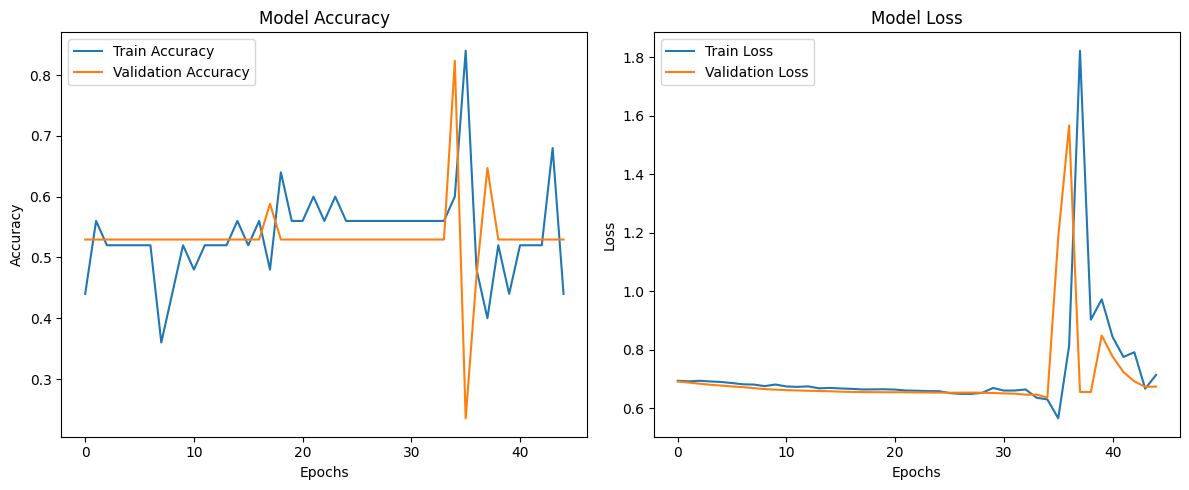

In [ ]:
plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step - accuracy: 0.8235 - loss: 0.6359
Test Accuracy: 0.8235, Test Loss: 0.6359
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.88      0.78      0.82         9

    accuracy                           0.82        17
   macro avg       0.83      0.83      0.82        17
weighted avg       0.83      0.82      0.82        17



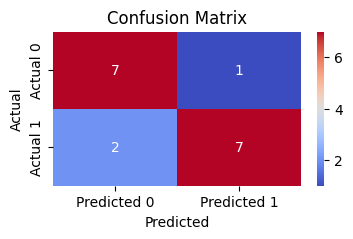

In [ ]:
evaluate_test_predictions(model, [X_timeseries_test])

## 2-Modal: Timeseries + Questionnaires

In [ ]:
# Time Series Input (LSTM)
num_timeseries_features = X_timeseries_train.shape[2]
time_input = Input(shape=(None, num_timeseries_features), name="Time_Series_Input")
ts = LSTM(64, return_sequences=True)(time_input)
ts = Dropout(0.2)(ts)
ts = LSTM(32, return_sequences=False)(ts)
ts = Dropout(0.2)(ts)
ts = Dense(16, activation='relu')(ts)

## Questionnaire Input (Dense)
num_questionnaire_features = X_categorical_train.shape[1]
questionnaire_input = Input(shape=(num_questionnaire_features,), name='Questionnaire_Input')
q = Dense(64, activation='relu')(questionnaire_input)
q = Dropout(0.2)(q)
q = Dense(32, activation='relu')(q)
q = Dropout(0.2)(q)
q = Dense(16, activation='relu')(q)

## Merge all inputs
merged = Concatenate()([ts, q])
output = Dense(1, activation='sigmoid', name="Output")(merged)

# Define model
model = Model(inputs=[time_input, questionnaire_input], outputs=output)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Time_Series_Input         │ (None, None, 61)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Questionnaire_Input       │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, None, 64)       │         32,256 │ Time_Series_Input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │            896 │ Questionnaire_Input[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, None, 64)       │              0 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64)             │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 32)             │         12,416 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 32)             │          2,080 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32)             │              0 │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 32)             │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 16)             │            528 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 16)             │            528 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32)             │              0 │ dense_2[0][0],         │
│                           │                        │                │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Output (Dense)            │ (None, 1)              │             33 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 48,737 (190.38 KB)

 Trainable params: 48,737 (190.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
filename = 'two-modal-ts-q-exclude-biomarkers' # Two modal timeseries and questionnaires (Excluding biomarker data)
two_modal_path = os.path.join(saved_models, f"{filename}.h5")
two_modal_history = os.path.join(model_history, f"{filename}.pkl")

# If this model exists, don't do any more traing
if os.path.exists(two_modal_path) and os.path.exists(two_modal_history):
    print(f"Model already exists")
else:
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    checkpoint_callback = ModelCheckpoint(
        filepath=two_modal_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    # Train the Model
    history = model.fit(
        [X_timeseries_train, X_categorical_train], y_train,
        epochs=500,
        batch_size=8,
        validation_data=([X_timeseries_test, X_categorical_test], y_test),
        callbacks=[early_stop, checkpoint_callback]
    )

    # Save history
    with open(two_modal_history, 'wb') as f:
        pickle.dump(history, f)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5927 - loss: 0.6890 
Epoch 1: val_accuracy improved from -inf to 0.58824, saving model to /content/drive/MyDrive/CECS 698 - Data Analysis/Saved Models 2/two-modal-ts-q-exclude-biomarkers.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 286ms/step - accuracy: 0.5942 - loss: 0.6888 - val_accuracy: 0.5882 - val_loss: 0.6810
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6296 - loss: 0.6813 
Epoch 2: val_accuracy did not improve from 0.58824
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6157 - loss: 0.6823 - val_accuracy: 0.5882 - val_loss: 0.6718
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6131 - loss: 0.7052
Epoch 3: val_accuracy did not improve from 0.58824
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.6185 - loss: 0.7017 - val_accuracy: 0.5882 - val_loss: 0.6631
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5050 - loss: 0.6577 
Epoch 4: val_accuracy did not improve from 0.58824
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.5080 - loss: 0.6569 - val_accuracy: 0.5294 - val_loss: 0.6561
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.6560 - loss: 0.6799 
Epoch 5: val_accuracy did not improve from 0.588

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.5073 - loss: 0.6902 - val_accuracy: 0.6471 - val_loss: 0.6335
Epoch 10/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.4485 - loss: 0.6538
Epoch 10: val_accuracy did not improve from 0.64706
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.4468 - loss: 0.6552 - val_accuracy: 0.6471 - val_loss: 0.6290
Epoch 11/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.5050 - loss: 0.6867
Epoch 11: val_accuracy improved from 0.64706 to 0.70588, saving model to /content/drive/MyDrive/CECS 698 - Data Analysis/Saved Models 2/two-modal-ts-q-exclude-biomarkers.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.5080 - loss: 0.6830 - val_accuracy: 0.7059 - val_loss: 0.6243
Epoch 12/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6744 - loss: 0.6603
Epoch 12: val_accuracy did not improve from 0.70588
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.6915 - loss: 0.6541 - val_accuracy: 0.7059 - val_loss: 0.6227
Epoch 13/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7317 - loss: 0.6195 
Epoch 13: val_accuracy did not improve from 0.70588
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7373 - loss: 0.6181 - val_accuracy: 0.6471 - val_loss: 0.6228
Epoch 14/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5615 - loss: 0.6337
Epoch 14: val_accuracy did not improve from 0.70588
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5692 - loss: 0.6324 - val_accuracy: 0.6471 - val_loss: 0.6223
Epoch 15/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7065 - loss: 0.5987
Epoch 15: val_accuracy did not improve fro

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.7165 - loss: 0.4042 - val_accuracy: 0.8235 - val_loss: 0.4752
Epoch 43/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7008 - loss: 0.5678 
Epoch 43: val_accuracy did not improve from 0.82353
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.7047 - loss: 0.5648 - val_accuracy: 0.6471 - val_loss: 0.6865
Epoch 44/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8967 - loss: 0.4016 
Epoch 44: val_accuracy did not improve from 0.82353
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.9013 - loss: 0.3997 - val_accuracy: 0.5294 - val_loss: 0.6755
Epoch 45/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9592 - loss: 0.3363 
Epoch 45: val_accuracy did not improve from 0.82353
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9513 - loss: 0.3459 - val_accuracy: 0.5882 - val_loss: 0.6748
Epoch 46/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9327 - loss: 0.3600 
Epoch 46: val_accuracy did not improve f

In [ ]:
# Load model (With best parameters for maximal accuracy)
model = load_model(two_modal_path)

# Load model history
with open(two_modal_history, 'rb') as f:
    history = pickle.load(f)

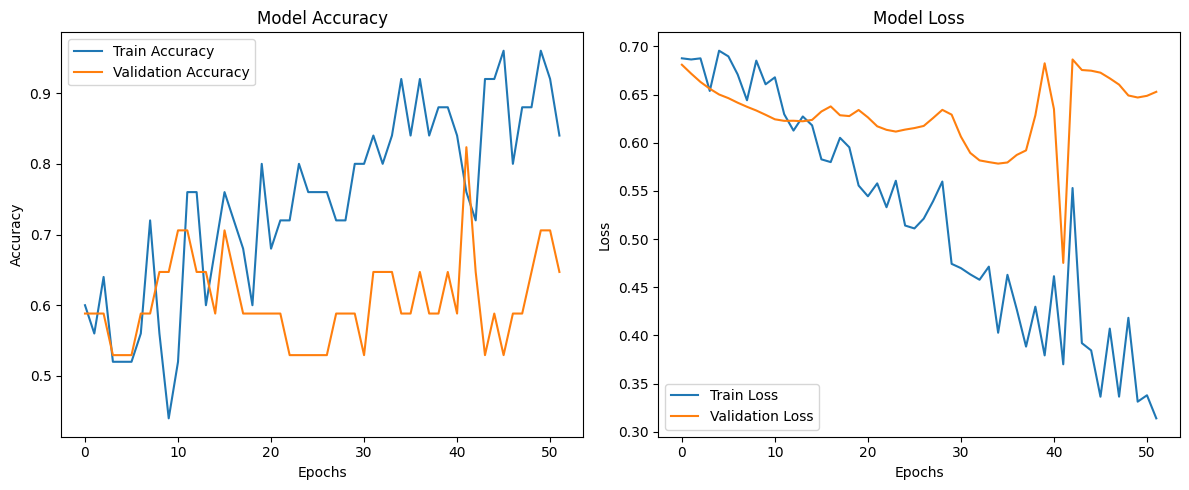

In [ ]:
plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step - accuracy: 0.8235 - loss: 0.4752
Test Accuracy: 0.8235, Test Loss: 0.4752
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
              precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       1.00      0.67      0.80         9

    accuracy                           0.82        17
   macro avg       0.86      0.83      0.82        17
weighted avg       0.87      0.82      0.82        17



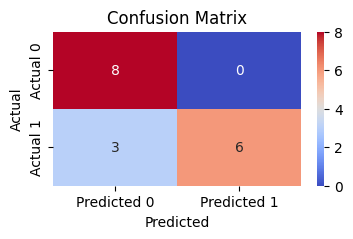

In [ ]:
evaluate_test_predictions(model, [X_timeseries_test, X_categorical_test])

## 2-Modal: Timeseries + Images

In [ ]:
# Time Series Input (LSTM)
num_timeseries_features = X_timeseries_train.shape[2]
time_input = Input(shape=(None, num_timeseries_features), name="Time_Series_Input")
ts = LSTM(64, return_sequences=True)(time_input)
ts = Dropout(0.2)(ts)
ts = LSTM(32, return_sequences=False)(ts)
ts = Dropout(0.2)(ts)
ts = Dense(16, activation='relu')(ts)

# Image Input (CNN)
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 1)
image_input = Input(shape=input_shape, name="Image_Input")
img = Conv2D(64, (3, 3), activation='relu')(image_input)
img = MaxPooling2D((2, 2))(img)
img = Conv2D(32, (3, 3), activation='relu')(img)
img = MaxPooling2D((2, 2))(img)
img = Conv2D(16, (3, 3), activation='relu')(img)
img = MaxPooling2D((2, 2))(img)
img = Flatten()(img)
img = Dense(64, activation='relu')(img)

## Merge all inputs
merged = Concatenate()([ts, img])
output = Dense(1, activation='sigmoid', name="Output")(merged)

# Define model
model = Model(inputs=[time_input, image_input], outputs=output)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Image_Input (InputLayer)  │ (None, 70, 70, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 68, 68, 64)     │            640 │ Image_Input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 34, 34, 64)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Time_Series_Input         │ (None, None, 61)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 32)     │         18,464 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, None, 64)       │         32,256 │ Time_Series_Input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 16, 16, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, None, 64)       │              0 │ lstm_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 14, 14, 16)     │          4,624 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 32)             │         12,416 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 7, 7, 16)       │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 32)             │              0 │ lstm_5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 784)            │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 16)             │            528 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 64)             │         50,240 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 80)             │              0 │ dense_6[0][0],         │
│ (Concatenate)             │                        │                │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Output (Dense)            │ (None, 1)              │             81 │ concatenate_1[0][0]    │
└──────────────────────

 Total params: 119,249 (465.82 KB)

 Trainable params: 119,249 (465.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
filename = 'two-modal-ts-img-exclude-biomarkers' # Two modal timeseries and images (Excluding biomarker data)
two_modal_path2 = os.path.join(saved_models, f"{filename}.h5")
two_modal_history2 = os.path.join(model_history, f"{filename}.pkl")

# If this model exists, don't do any more traing
if os.path.exists(two_modal_path2) and os.path.exists(two_modal_history2):
    print(f"Model already exists")
else:
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    checkpoint_callback = ModelCheckpoint(
        filepath=two_modal_path2,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    # Train the Model
    history = model.fit(
        [X_timeseries_train, X_image_train], y_train,
        epochs=500,
        batch_size=8,
        validation_data=([X_timeseries_test, X_image_test], y_test),
        callbacks=[early_stop, checkpoint_callback]
    )

    # Save history
    with open(two_modal_history2, 'wb') as f:
        pickle.dump(history, f)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.5575 - loss: 0.7128
Epoch 1: val_accuracy improved from -inf to 0.35294, saving model to /content/drive/MyDrive/CECS 698 - Data Analysis/Saved Models 2/two-modal-ts-img-exclude-biomarkers.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 321ms/step - accuracy: 0.5420 - loss: 0.7156 - val_accuracy: 0.3529 - val_loss: 0.6917
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8510 - loss: 0.6614
Epoch 2: val_accuracy improved from 0.35294 to 0.52941, saving model to /content/drive/MyDrive/CECS 698 - Data Analysis/Saved Models 2/two-modal-ts-img-exclude-biomarkers.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.8408 - loss: 0.6606 - val_accuracy: 0.5294 - val_loss: 0.6842
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.5567 - loss: 0.6492
Epoch 3: val_accuracy did not improve from 0.52941
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.5573 - loss: 0.6473 - val_accuracy: 0.5294 - val_loss: 0.6909
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.4942 - loss: 0.6444
Epoch 4: val_accuracy did not improve from 0.52941
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.5073 - loss: 0.6385 - val_accuracy: 0.5294 - val_loss: 0.7317
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.6083 - loss: 0.6010
Epoch 5: val_accuracy did not improve from 0.52941
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.6067 - loss: 0.6009 - val_accuracy: 0.4706 - val_loss: 0.7394
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6227 - loss: 0.5572
Epoch 6: val_accuracy improved from 0.52941 to 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.6422 - loss: 0.5487 - val_accuracy: 0.6471 - val_loss: 0.6647
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7933 - loss: 0.4610
Epoch 7: val_accuracy improved from 0.64706 to 0.70588, saving model to /content/drive/MyDrive/CECS 698 - Data Analysis/Saved Models 2/two-modal-ts-img-exclude-biomarkers.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.8027 - loss: 0.4533 - val_accuracy: 0.7059 - val_loss: 0.6875
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8558 - loss: 0.4234
Epoch 8: val_accuracy did not improve from 0.70588
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.8527 - loss: 0.4177 - val_accuracy: 0.7059 - val_loss: 0.7467
Epoch 9/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8867 - loss: 0.2583
Epoch 9: val_accuracy did not improve from 0.70588
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.8853 - loss: 0.2669 - val_accuracy: 0.5882 - val_loss: 0.7752
Epoch 10/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9435 - loss: 0.1653
Epoch 10: val_accuracy did not improve from 0.70588
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.9388 - loss: 0.1746 - val_accuracy: 0.7059 - val_loss: 0.6442
Epoch 11/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 1.0000 - loss: 0.1717
Epoch 11: val_accuracy did not improve from 

In [ ]:
# Load model (With best parameters for maximal accuracy)
model = load_model(two_modal_path2)

# Load model history
with open(two_modal_history2, 'rb') as f:
    history = pickle.load(f)

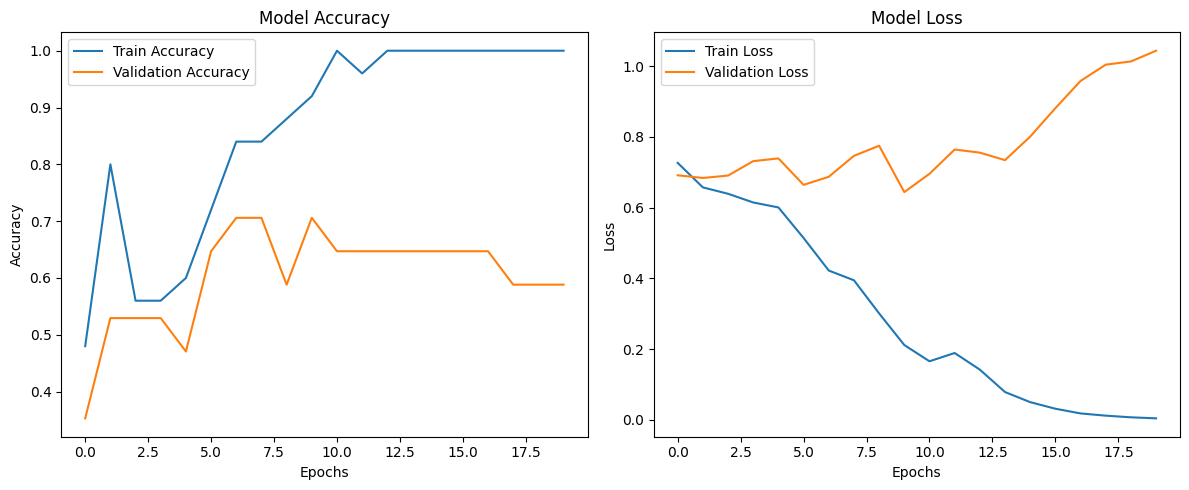

In [ ]:
plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step - accuracy: 0.7059 - loss: 0.6875
Test Accuracy: 0.7059, Test Loss: 0.6875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.75      0.67      0.71         9

    accuracy                           0.71        17
   macro avg       0.71      0.71      0.71        17
weighted avg       0.71      0.71      0.71        17



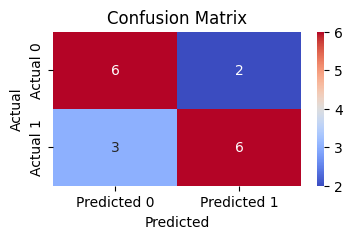

In [ ]:
evaluate_test_predictions(model, [X_timeseries_test, X_image_test])

## 3-Modal: Timeseries + Questionnaires + Images

In [ ]:
# Time Series Input (LSTM)
num_timeseries_features = X_timeseries_train.shape[2]
time_input = Input(shape=(None, num_timeseries_features), name="Time_Series_Input")
ts = LSTM(64, return_sequences=True)(time_input)
ts = Dropout(0.2)(ts)
ts = LSTM(32, return_sequences=False)(ts)
ts = Dropout(0.2)(ts)
ts = Dense(16, activation='relu')(ts)

## Questionnaire Input (Dense)
num_questionnaire_features = X_categorical_train.shape[1]
questionnaire_input = Input(shape=(num_questionnaire_features,), name='Questionnaire_Input')
q = Dense(64, activation='relu')(questionnaire_input)
q = Dropout(0.2)(q)
q = Dense(32, activation='relu')(q)
q = Dropout(0.2)(q)
q = Dense(16, activation='relu')(q)

# Image Input (CNN)
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 1)
image_input = Input(shape=input_shape, name="Image_Input")
img = Conv2D(64, (3, 3), activation='relu')(image_input)
img = MaxPooling2D((2, 2))(img)
img = Conv2D(32, (3, 3), activation='relu')(img)
img = MaxPooling2D((2, 2))(img)
img = Conv2D(16, (3, 3), activation='relu')(img)
img = MaxPooling2D((2, 2))(img)
img = Flatten()(img)
img = Dense(64, activation='relu')(img)

## Merge all inputs
merged = Concatenate()([ts, q, img])
output = Dense(1, activation='sigmoid', name="Output")(merged)

# Define model
model = Model(inputs=[time_input, questionnaire_input, image_input], outputs=output)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Image_Input (InputLayer)  │ (None, 70, 70, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 68, 68, 64)     │            640 │ Image_Input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 34, 34, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Time_Series_Input         │ (None, None, 61)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Questionnaire_Input       │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 32)     │         18,464 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ (None, None, 64)       │         32,256 │ Time_Series_Input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 64)             │            896 │ Questionnaire_Input[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 16, 16, 32)     │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, None, 64)       │              0 │ lstm_6[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 64)             │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 14, 14, 16)     │          4,624 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ (None, 32)             │         12,416 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 32)             │          2,080 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 7, 7, 16)       │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 32)             │              0 │ lstm_7[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 32)             │              0 │ dense_10[0][0]         │
├──────────────────────

 Total params: 122,769 (479.57 KB)

 Trainable params: 122,769 (479.57 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # Visualize model structure
# plot_model(
#     model,
#     show_shapes=True,  # Display input/output shapes
#     show_layer_names=True,  # Display layer names
#     expand_nested=True,  # Expand nested models if any
#     dpi=60  # Adjust resolution
# )

In [ ]:
filename = 'three-modal-exclude-biomarkers' # All 3 modals (Excluding biomarker data)
three_modal_path = os.path.join(saved_models, f"{filename}.h5")
three_modal_history = os.path.join(model_history, f"{filename}.pkl")

# If this model exists, don't do any more traing
if os.path.exists(three_modal_path) and os.path.exists(three_modal_history):
    print(f"Model already exists")
else:
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    checkpoint_callback = ModelCheckpoint(
        filepath=three_modal_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    # Train the Model
    history = model.fit(
        [X_timeseries_train, X_categorical_train, X_image_train], y_train,
        epochs=500,
        batch_size=8,
        validation_data=([X_timeseries_test, X_categorical_test, X_image_test], y_test),
        callbacks=[early_stop, checkpoint_callback]
    )

    # Save history
    with open(three_modal_history, 'wb') as f:
        pickle.dump(history, f)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5831 - loss: 0.6941
Epoch 1: val_accuracy improved from -inf to 0.52941, saving model to /content/drive/MyDrive/CECS 698 - Data Analysis/Saved Models 2/three-modal-exclude-biomarkers.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 315ms/step - accuracy: 0.5705 - loss: 0.6960 - val_accuracy: 0.5294 - val_loss: 0.6839
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.4942 - loss: 0.6695
Epoch 2: val_accuracy did not improve from 0.52941
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 0.5073 - loss: 0.6657 - val_accuracy: 0.5294 - val_loss: 0.6838
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.5458 - loss: 0.6578
Epoch 3: val_accuracy did not improve from 0.52941
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step - accuracy: 0.5567 - loss: 0.6544 - val_accuracy: 0.5294 - val_loss: 0.6839
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6600 - loss: 0.6099
Epoch 4: val_accuracy did not improve from 0.52941
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.6560 - loss: 0.6055 - val_accuracy: 0.4706 - val_loss: 0.7092
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.6696 - loss: 0.5834
Epoch 5: val_accuracy improved from 0.52941 to 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.6797 - loss: 0.5746 - val_accuracy: 0.5882 - val_loss: 0.7280
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7885 - loss: 0.5298
Epoch 6: val_accuracy improved from 0.58824 to 0.70588, saving model to /content/drive/MyDrive/CECS 698 - Data Analysis/Saved Models 2/three-modal-exclude-biomarkers.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.7908 - loss: 0.5190 - val_accuracy: 0.7059 - val_loss: 0.7283
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8402 - loss: 0.3992
Epoch 7: val_accuracy did not improve from 0.70588
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.8402 - loss: 0.4007 - val_accuracy: 0.7059 - val_loss: 0.7814
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8871 - loss: 0.2861
Epoch 8: val_accuracy did not improve from 0.70588
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.8777 - loss: 0.3011 - val_accuracy: 0.6471 - val_loss: 0.9521
Epoch 9/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7777 - loss: 0.3547
Epoch 9: val_accuracy did not improve from 0.70588
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.7902 - loss: 0.3457 - val_accuracy: 0.6471 - val_loss: 0.7841
Epoch 10/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8450 - loss: 0.2631
Epoch 10: val_accuracy did not improve from 0.

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 1.0000 - loss: 0.0912 - val_accuracy: 0.7647 - val_loss: 0.6919
Epoch 12: early stopping


In [ ]:
# Load model (With best parameters for maximal accuracy)
model = load_model(three_modal_path)

# Load model history
with open(three_modal_history, 'rb') as f:
    history = pickle.load(f)

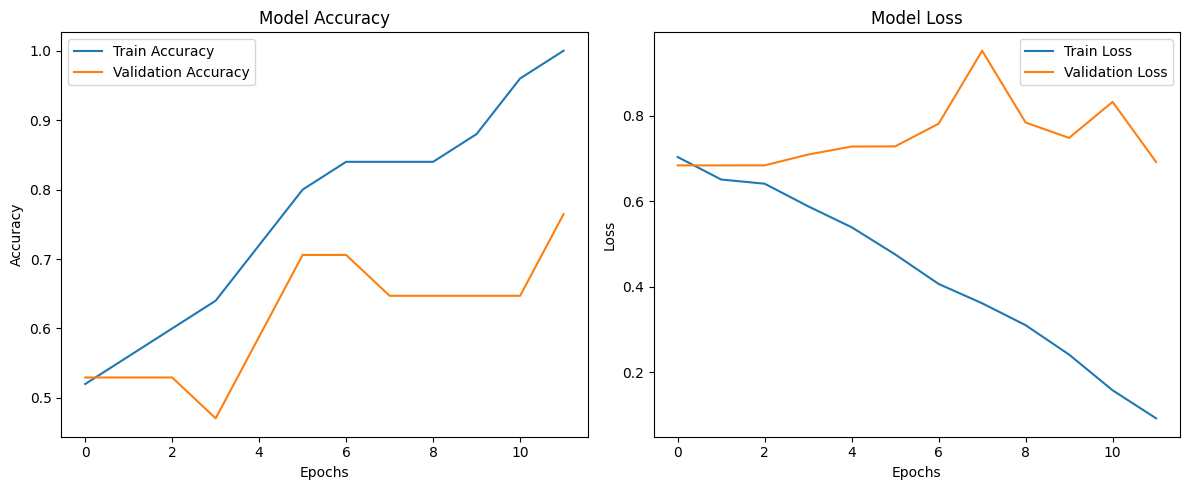

In [ ]:
plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step - accuracy: 0.7647 - loss: 0.6919
Test Accuracy: 0.7647, Test Loss: 0.6919
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.78      0.78      0.78         9

    accuracy                           0.76        17
   macro avg       0.76      0.76      0.76        17
weighted avg       0.76      0.76      0.76        17



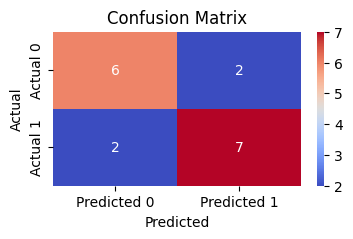

In [ ]:
evaluate_test_predictions(model, [X_timeseries_test, X_categorical_test, X_image_test])

# Saving test data to be used later

In [ ]:
test_data_path = os.path.join(CECS_698_PATH, 'Test Data', 'Eyetracker Only') # Test data including eye tracking and biomarkers
if not os.path.exists(test_data_path):
    os.makedirs(test_data_path)
    print(f"Created {test_data_path}")
else:
    print(f"{test_data_path} already exists")

Created /content/drive/MyDrive/CECS 698 - Data Analysis/Test Data/Eyetracker Only


In [ ]:
# Saving
file = os.path.join(test_data_path, f"X_timeseries_test.pkl")
with open(file, 'wb') as f:
    pickle.dump(X_timeseries_test, f)

file = os.path.join(test_data_path, f"X_categorical_test.pkl")
with open(file, 'wb') as f:
    pickle.dump(X_categorical_test, f)

file = os.path.join(test_data_path, f"X_image_test.pkl")
with open(file, 'wb') as f:
    pickle.dump(X_image_test, f)